# Sentiment Analysis

In [1]:
# Import libraries
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import re
from datasets import Dataset, DatasetDict
# from datasets import load_dataset
# import evaluate

import transformers
from transformers import BertTokenizerFast, DataCollatorForTokenClassification, AutoModelForTokenClassification, TrainingArguments, Trainer, pipeline, TFBertForSequenceClassification, create_optimizer


from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,InputLayer,BatchNormalization, Dropout,Input,LayerNormalization
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam

c:\anaconda3\envs\torchdev\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_nlp = pd.read_csv('../data/bank_reviews3.csv')
df_nlp.columns
df_nlp.shape
pd.unique(df_nlp['rating'])

array([4. , 5. , 3. , 4.5, 0.5, 2. , 3.5, 1.5, 1. , 2.5])

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
train_df = df_nlp.iloc[0:900, ]
test_df = df_nlp.iloc[900:, ]
train_reviews = train_df['review']
train_target = train_df['rating']
x_test = test_df['review']
y_test = test_df['rating']

# Split data into train and validation
x_train, x_val, y_train, y_val = train_test_split(train_reviews, train_target,
                 test_size = 0.2)

In [5]:
train_df = train_df[['review', 'rating']]
test_df = train_df[['review', 'rating']]

# Tenserflow

In [ ]:
train_dataset = Dataset.from_dict({'text': x_train,
                                   'label': y_train})
test_dataset = Dataset.from_dict({'text':x_test,
                                 'label': y_test})
val_dataset = Dataset.from_dict({'text':x_val,
                                 'label':y_val})
dataset = DatasetDict({
    'train':train_dataset,
    'val':val_dataset,
    'test':test_dataset
})
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 720
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 180
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 100
    })
})


In [4]:
# Tokenization
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

# Encoding
max_len = 128
x_train_encoded = tokenizer.batch_encode_plus(x_train.tolist(),
                                              padding = True,
                                              truncation = True,
                                              max_length = max_len,
                                              return_tensors = 'tf')

x_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(),
                                            padding  = True,
                                            truncation = True,
                                            max_length = max_len,
                                            return_tensors = 'tf')

x_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(),
                                             padding = True,
                                             truncation = True,
                                             max_length = max_len,
                                             return_tensors  ='tf')

In [8]:
# Intialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer

# Assuming x_train_encoded is already prepared with tokenized data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# Step 1: Extract embeddings using GradientTape
with tf.GradientTape() as tape:
    embeddings = model.bert.embeddings(input_ids=x_train_encoded['input_ids'])

# Step 2: Normalize the embeddings using LayerNormalization
layer_norm = tf.keras.layers.LayerNormalization()
normalized_embeddings = layer_norm.call(embeddings)

# Debugging: Check the shape and type
print(f"Normalized Embeddings Shape: {normalized_embeddings.shape}")
print(f"Type: {type(normalized_embeddings)}")

# Step 3: Use the normalized embeddings for the BERT model
outputs = model(
    inputs_embeds=normalized_embeddings,
    attention_mask=x_train_encoded['attention_mask']
)

# Check the model outputs
print("Model outputs:", outputs)


TypeError: 'int' object is not iterable

In [ ]:
# tokenizer.decode(x_test_encoded['input_ids'][1])

"[CLS] i ' m having my savings account with kotak mahindra bank. since its a zero balance account so that i had selected this bank. on yearly once, they are charging rs. 200 for the debit card. once i had faced a issue like they have blocked my account due to signature mismatch. once i visited their branch, they said it will take one week to resolve my issue. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

In [ ]:
# Intialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)
model.summary()

# Compile the model with a regression loss function
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])

# Train the model
history = model.fit(
    x_train_encoded['embeddings'],
    y_train,
    validation_data=(x_train_encoded['embeddings'], y_val),
    epochs=5,
    batch_size=16
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
 

ValueError: in user code:

    File "c:\anaconda3\envs\torchdev\lib\site-packages\tf_keras\src\engine\training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "c:\anaconda3\envs\torchdev\lib\site-packages\tf_keras\src\engine\training.py", line 1381, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\anaconda3\envs\torchdev\lib\site-packages\tf_keras\src\engine\training.py", line 1370, in run_step  **
        outputs = model.train_step(data)
    File "c:\anaconda3\envs\torchdev\lib\site-packages\transformers\modeling_tf_utils.py", line 1672, in train_step
        y_pred = self(x, training=True)
    File "c:\anaconda3\envs\torchdev\lib\site-packages\tf_keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\YANGLI~1\AppData\Local\Temp\__autograph_generated_filekxt0se2u.py", line 37, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "C:\Users\YANGLI~1\AppData\Local\Temp\__autograph_generated_file0jbiaxnt.py", line 17, in tf__call
        outputs = ag__.converted_call(ag__.ld(self).bert, (), dict(input_ids=ag__.ld(input_ids), attention_mask=ag__.ld(attention_mask), token_type_ids=ag__.ld(token_type_ids), position_ids=ag__.ld(position_ids), head_mask=ag__.ld(head_mask), inputs_embeds=ag__.ld(inputs_embeds), output_attentions=ag__.ld(output_attentions), output_hidden_states=ag__.ld(output_hidden_states), return_dict=ag__.ld(return_dict), training=ag__.ld(training)), fscope)
    File "C:\Users\YANGLI~1\AppData\Local\Temp\__autograph_generated_filekxt0se2u.py", line 37, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "C:\Users\YANGLI~1\AppData\Local\Temp\__autograph_generated_file39e7wjf7.py", line 76, in tf__call
        (batch_size, seq_length) = ag__.ld(input_shape)

    ValueError: Exception encountered when calling layer 'tf_bert_for_sequence_classification_1' (type TFBertForSequenceClassification).
    
    in user code:
    
        File "c:\anaconda3\envs\torchdev\lib\site-packages\transformers\modeling_tf_utils.py", line 1734, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "c:\anaconda3\envs\torchdev\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 1746, in call  *
            outputs = self.bert(
        File "c:\anaconda3\envs\torchdev\lib\site-packages\tf_keras\src\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "C:\Users\YANGLI~1\AppData\Local\Temp\__autograph_generated_filekxt0se2u.py", line 37, in tf__run_call_with_unpacked_inputs
            retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
        File "C:\Users\YANGLI~1\AppData\Local\Temp\__autograph_generated_file39e7wjf7.py", line 76, in tf__call
            (batch_size, seq_length) = ag__.ld(input_shape)
    
        ValueError: Exception encountered when calling layer 'bert' (type TFBertMainLayer).
        
        in user code:
        
            File "c:\anaconda3\envs\torchdev\lib\site-packages\transformers\modeling_tf_utils.py", line 1734, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "c:\anaconda3\envs\torchdev\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 873, in call  *
                batch_size, seq_length = input_shape
        
            ValueError: too many values to unpack (expected 2)
        
        
        Call arguments received by layer 'bert' (type TFBertMainLayer):
          • input_ids=tf.Tensor(shape=(16, 128, 768), dtype=float32)
          • attention_mask=None
          • token_type_ids=None
          • position_ids=None
          • head_mask=None
          • inputs_embeds=None
          • encoder_hidden_states=None
          • encoder_attention_mask=None
          • past_key_values=None
          • use_cache=None
          • output_attentions=False
          • output_hidden_states=False
          • return_dict=True
          • training=True
    
    
    Call arguments received by layer 'tf_bert_for_sequence_classification_1' (type TFBertForSequenceClassification):
      • input_ids=tf.Tensor(shape=(16, 128, 768), dtype=float32)
      • attention_mask=None
      • token_type_ids=None
      • position_ids=None
      • head_mask=None
      • inputs_embeds=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None
      • labels=None
      • training=True


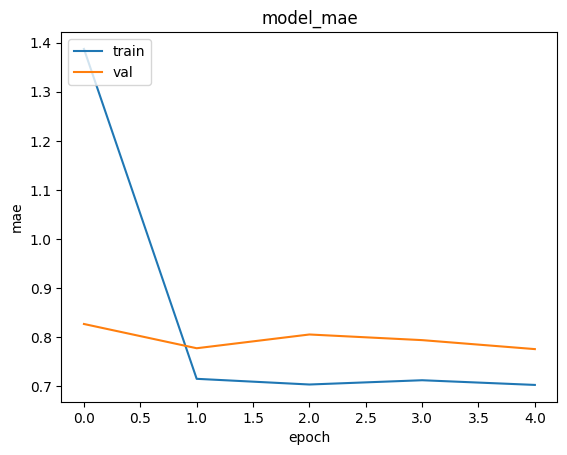

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

plt.title('model_mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Test on test data
predictions = model.predict(x_test_encoded['input_ids'])


4/4 [==============================] - 32s 6s/step


In [ ]:
predicted_ratings = predictions.logits.flatten()
predicted_ratings_rounded = tf.round(predicted_ratings).numpy()

print("Predicted Ratings (Continuous):", predicted_ratings[:5])

Predicted Ratings (Continuous): [4.561192  4.5611916 4.5611916 4.5611916 4.5611916]


In [ ]:
predicted_ratings

array([4.561192 , 4.5611916, 4.5611916, 4.5611916, 4.5611916, 4.5611916,
       4.5611916, 4.5611916, 4.561192 , 4.5611916, 4.5611916, 4.5611916,
       4.5611916, 4.5611916, 4.5611916, 4.5611916, 4.5611916, 4.5611916,
       4.5611916, 4.561192 , 4.5611916, 4.5611916, 4.5611916, 4.5611916,
       4.5611916, 4.5611916, 4.5611916, 4.5611916, 4.5611916, 4.5611916,
       4.5611916, 4.5611916, 4.5611916, 4.561192 , 4.5611916, 4.5611916,
       4.5611916, 4.5611916, 4.5611916, 4.5611916, 4.5611916, 4.5611916,
       4.5611916, 4.5611916, 4.561192 , 4.5611916, 4.5611916, 4.5611916,
       4.5611916, 4.5611916, 4.5611916, 4.5611916, 4.5611916, 4.5611916,
       4.5611916, 4.5611916, 4.5611916, 4.5611916, 4.5611916, 4.5611916,
       4.5611916, 4.5611916, 4.5611916, 4.5611916, 4.5611916, 4.5611916,
       4.5611916, 4.561192 , 4.5611916, 4.5611916, 4.5611916, 4.5611916,
       4.5611916, 4.5611916, 4.5611916, 4.5611916, 4.5611916, 4.5611916,
       4.5611916, 4.5611916, 4.5611916, 4.5611916, 

In [ ]:
y_test

900    2.0
901    5.0
902    5.0
903    5.0
904    5.0
      ... 
995    3.5
996    4.0
997    4.0
998    5.0
999    4.0
Name: rating, Length: 100, dtype: float64